# Jumpman 23 NYC Analysis

### Nathan Hearnsberger 
#### nhearnsberger@gmail.com


As can be seen to the right, New York City's orders are highly concentrated in Lower Manhattan. 

Click the "Pickups" or "Dropoffs" button and then a vehicle type or place category to view a heatmap of the order quantity. 


In [84]:
%matplotlib inline 
import pandas as pd
import seaborn as sns
import json
from urllib.request import urlopen,urlretrieve
from shapely.geometry import shape as Shape, Point


#Read to DataFrame and date/time formatting
df = pd.read_csv('./data/analyze_me.csv',
                 parse_dates= ['when_the_delivery_started',
                              'when_the_Jumpman_arrived_at_pickup',
                              'when_the_Jumpman_left_pickup',
                              'when_the_Jumpman_arrived_at_dropoff'],
                 infer_datetime_format = True,
                 converters = {'how_long_it_took_to_order':pd.to_timedelta})

#Add fields for pickup/order wait times
df['pickup_wait_time'] = (df.when_the_Jumpman_left_pickup - df.when_the_Jumpman_arrived_at_pickup)   
df['order_wait_time'] = (df.when_the_Jumpman_arrived_at_dropoff - df.when_the_delivery_started)   


#Returns feature for coordinates using dict of feature:Shape
def getFeatureforPoint(shapeDict,lon,lat):
    point = Point(lon,lat)
    for feature, shape in shapeDict.items():
        if shape.contains(point):
            return(feature)

#Geodata from NYC OpenData 
boroughBoundaries = urlopen('https://data.cityofnewyork.us/resource/7t3b-ywvw.json').read().decode('utf-8')
boroughDict = { borough['boro_name']: Shape(borough['the_geom']) for borough in json.loads(boroughBoundaries)}

#NTA (Neighbordhood Tabulation Area) Boundaries 
ntaBoundaries = urlopen('https://data.cityofnewyork.us/resource/93vf-i5bz.json').read().decode('utf-8')
ntaDict = { nta['ntaname']: Shape(nta['the_geom']) for nta in json.loads(ntaBoundaries)}

#Add borough and NTA for each pickup/dropoff location
df['pickup_borough'] = df.apply(lambda row: getFeatureforPoint(boroughDict,  row['pickup_lon'], row['pickup_lat']), axis=1)
df['dropoff_borough'] = df.apply(lambda row: getFeatureforPoint(boroughDict, row['dropoff_lon'], row['dropoff_lat']), axis=1)
df['pickup_NTA'] = df.apply(lambda row: getFeatureforPoint(ntaDict,  row['pickup_lon'], row['pickup_lat']), axis=1)
df['dropoff_NTA'] = df.apply(lambda row: getFeatureforPoint(ntaDict, row['dropoff_lon'], row['dropoff_lat']), axis=1)

In [46]:
df.head()

,delivery_id,customer_id,jumpman_id,vehicle_type,pickup_place,place_category,item_name,item_quantity,item_category_name,how_long_it_took_to_order,...,when_the_delivery_started,when_the_Jumpman_arrived_at_pickup,when_the_Jumpman_left_pickup,when_the_Jumpman_arrived_at_dropoff,pickup_wait_time,order_wait_time,pickup_borough,dropoff_borough,pickup_NTA,dropoff_NTA
0,1457973,327168,162381,van,Melt Shop,American,Lemonade,1.0,Beverages,0 days 00:19:58.582052000,...,2014-10-26 13:51:59.898924,NaN,NaN,2014-10-26 14:52:06.313088,NaN,0 days 01:00:06.414164000,Manhattan,Manhattan,Hudson Yards-Chelsea-Flatiron-Union Square,Midtown-Midtown South
1,1377056,64452,104533,bicycle,Prince Street Pizza,Pizza,Neapolitan Rice Balls,3.0,Munchables,0 days 00:25:09.107093000,...,2014-10-16 21:58:58.654910,2014-10-16 22:26:02.120931,2014-10-16 22:48:23.091253,2014-10-16 22:59:22.948873,0 days 00:22:20.970322000,0 days 01:00:24.293963000,Manhattan,Manhattan,SoHo-TriBeCa-Civic Center-Little Italy,Chinatown
2,1476547,83095,132725,bicycle,Bareburger,Burger,Bare Sodas,1.0,Drinks,0 days 00:06:44.541717000,...,2014-10-28 21:39:52.654394,2014-10-28 21:37:18.793405,2014-10-28 21:59:09.984810,2014-10-28 22:04:40.634962,0 days 00:21:51.191405000,0 days 00:24:47.980568000,Manhattan,Manhattan,West Village,West Village
3,1485494,271149,157175,bicycle,Juice Press,Juice Bar,OMG! My Favorite Juice!,1.0,Cold Pressed Juices,NaN,...,2014-10-30 10:54:11.531894,2014-10-30 11:04:17.759577,2014-10-30 11:16:37.895816,2014-10-30 11:32:38.090061,0 days 00:12:20.136239000,0 days 00:38:26.558167000,Manhattan,Manhattan,West Village,Hudson Yards-Chelsea-Flatiron-Union Square
4,1327707,122609,118095,bicycle,Blue Ribbon Sushi,Japanese,Spicy Tuna & Tempura Flakes,2.0,Maki (Special Rolls),0 days 00:03:45.035418000,...,2014-10-10 00:07:18.450505,2014-10-10 00:14:42.702223,2014-10-10 00:25:19.400294,2014-10-10 00:48:27.150595,0 days 00:10:36.698071000,0 days 00:41:08.700090000,Manhattan,Manhattan,SoHo-TriBeCa-Civic Center-Little Italy,Battery Park City-Lower Manhattan


# Local Order Volume


In [45]:
for field, desc in {'delivery_id':'orders','pickup_place':'pickup places',
        'customer_id':'customers','jumpman_id':'delivers','item_name':'items','place_category':'place categories'}.items():
    print('Number of %s:'% desc,len(df[field].unique()))

Number of orders: 5214
Number of pickup places: 898
Number of customers: 3192
Number of delivers: 578
Number of items: 2278
Number of place categories: 58


In [48]:
df.groupby('dropoff_borough').size().reset_index(name='count')

,dropoff_borough,count
0,Brooklyn,238
1,Manhattan,5740
2,Queens,5


In [60]:
print('Dropoffs by neighborhood')
df.groupby('dropoff_NTA').size().sort_values(ascending=False).reset_index(name='count').head(20)

Dropoffs by neighborhood


,dropoff_NTA,count
0,SoHo-TriBeCa-Civic Center-Little Italy,823
1,West Village,806
2,Hudson Yards-Chelsea-Flatiron-Union Square,787
3,Midtown-Midtown South,470
4,Upper East Side-Carnegie Hill,456
5,East Village,260
6,Battery Park City-Lower Manhattan,241
7,Lenox Hill-Roosevelt Island,222
8,Lincoln Square,217
9,Murray Hill-Kips Bay,217


In [20]:
print('Cross-borough deliveries')
df[df.dropoff_borough != df.pickup_borough].groupby(['pickup_borough','dropoff_borough']).size() \
    .sort_values(ascending=False).reset_index(name='count')

Cross-borough deliveries


,pickup_borough,dropoff_borough,count
0,Manhattan,Brooklyn,47
1,Brooklyn,Manhattan,26
2,Manhattan,Queens,3
3,Brooklyn,Queens,1


In [21]:
print('Cross-neighborhood deliveries')
df[df.dropoff_NTA != df.pickup_NTA].groupby(['pickup_NTA','dropoff_NTA']).size() \
    .sort_values(ascending=False).reset_index(name='count').head(10)

Cross-neighborhood deliveries


,pickup_NTA,dropoff_NTA,count
0,SoHo-TriBeCa-Civic Center-Little Italy,West Village,183
1,East Village,West Village,141
2,West Village,SoHo-TriBeCa-Civic Center-Little Italy,129
3,East Village,SoHo-TriBeCa-Civic Center-Little Italy,128
4,Hudson Yards-Chelsea-Flatiron-Union Square,Midtown-Midtown South,112
5,Hudson Yards-Chelsea-Flatiron-Union Square,West Village,105
6,SoHo-TriBeCa-Civic Center-Little Italy,Hudson Yards-Chelsea-Flatiron-Union Square,102
7,East Village,Hudson Yards-Chelsea-Flatiron-Union Square,101
8,West Village,Hudson Yards-Chelsea-Flatiron-Union Square,98
9,SoHo-TriBeCa-Civic Center-Little Italy,Battery Park City-Lower Manhattan,81


In [132]:
print('Deliveries by day')
df.groupby(df.when_the_delivery_started.dt.weekday_name).size().sort_values(ascending=False).reset_index(name='count')

Deliveries by day


,when_the_delivery_started,count
0,Sunday,1119
1,Thursday,906
2,Wednesday,886
3,Saturday,848
4,Friday,827
5,Tuesday,713
6,Monday,684


In [49]:
list(df)

['delivery_id',
 'customer_id',
 'jumpman_id',
 'vehicle_type',
 'pickup_place',
 'place_category',
 'item_name',
 'item_quantity',
 'item_category_name',
 'how_long_it_took_to_order',
 'pickup_lat',
 'pickup_lon',
 'dropoff_lat',
 'dropoff_lon',
 'when_the_delivery_started',
 'when_the_Jumpman_arrived_at_pickup',
 'when_the_Jumpman_left_pickup',
 'when_the_Jumpman_arrived_at_dropoff',
 'pickup_wait_time',
 'order_wait_time',
 'pickup_borough',
 'dropoff_borough',
 'pickup_NTA',
 'dropoff_NTA']

In [81]:
df.groupby(['day','hour']).size()

day        hour
Friday     0        18
           1         1
           2         1
           7         5
           8         1
           9         6
           10       28
           11       48
           12       60
           13       58
           14       27
           15       32
           16       31
           17       49
           18       84
           19      137
           20      108
           21       81
           22       30
           23       22
Monday     0         6
           1         4
           2         4
           3         1
           7         2
           8         7
           9         8
           10       24
           11       33
           12       50
                  ... 
Tuesday    15       28
           16       25
           17       44
           18       94
           19      129
           20      102
           21       50
           22       21
           23       15
Wednesday  0        10
           1         4
           2      

,day,hour,count
0,Friday,0,18
1,Friday,1,1
2,Friday,2,1
3,Friday,7,5
4,Friday,8,1
5,Friday,9,6
6,Friday,10,28
7,Friday,11,48
8,Friday,12,60
9,Friday,13,58


In [105]:
list(df)

['delivery_id',
 'customer_id',
 'jumpman_id',
 'vehicle_type',
 'pickup_place',
 'place_category',
 'item_name',
 'item_quantity',
 'item_category_name',
 'how_long_it_took_to_order',
 'pickup_lat',
 'pickup_lon',
 'dropoff_lat',
 'dropoff_lon',
 'when_the_delivery_started',
 'when_the_Jumpman_arrived_at_pickup',
 'when_the_Jumpman_left_pickup',
 'when_the_Jumpman_arrived_at_dropoff',
 'pickup_wait_time',
 'order_wait_time',
 'pickup_borough',
 'dropoff_borough',
 'pickup_NTA',
 'dropoff_NTA',
 'hour',
 'day']

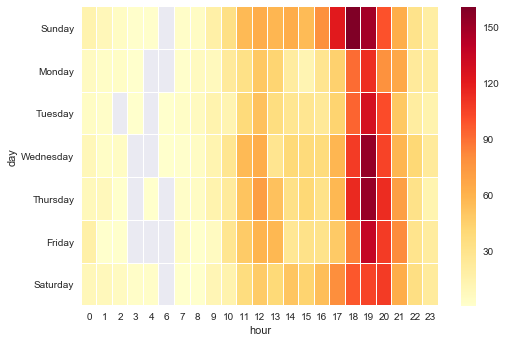

In [154]:
df['day'] = df.when_the_delivery_started.dt.weekday_name
df['hour'] = df.when_the_delivery_started.dt.hour
d = df.groupby(['day','hour']).size().reset_index(name='count').pivot('day','hour','count')
d.index = pd.CategoricalIndex(d.index, categories= ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"])
d.sort_index(level=0, inplace=True)
sns.heatmap(d,linewidths=.004,cmap='YlOrRd')

In [61]:
print('Most popular pickup places')
pickup_places = df.groupby('pickup_place').size()
pickup_places.sort_values(ascending=False).head(20).reset_index(name='count')


Most popular pickup places


,pickup_place,count
0,Shake Shack,311
1,Momofuku Milk Bar,186
2,The Meatball Shop,184
3,Blue Ribbon Sushi,151
4,sweetgreen,149
5,Blue Ribbon Fried Chicken,133
6,Whole Foods Market,119
7,Parm,102
8,RedFarm Broadway,93
9,Mighty Quinn's BBQ,90


In [32]:
print('Places with %s order: %s'%(1,len(pickup_places[pickup_places == 1])))
for x in [[2,5],[6,20],[20,max(pickup_places)]]:
    print('Places with %s to %s orders: %s'%(x[0],x[1],len(pickup_places[pickup_places.between(x[0],x[1])])) )  

Places with 1 order: 457
Places with 2 to 5 orders: 264
Places with 6 to 20 orders: 115
Places with 20 to 311 orders: 64


In [33]:
print('Customers with %s order: %s'%(1,len(customers[customers == 1])))
for x in [[2,5],[6,20],[20,max(customers)]]:
    print('Customers with %s to %s orders: %s'%(x[0],x[1],len(customers[customers.between(x[0],x[1])])) )  

Customers with 1 order: 1939
Customers with 2 to 5 orders: 1135
Customers with 6 to 20 orders: 116
Customers with 20 to 28 orders: 2


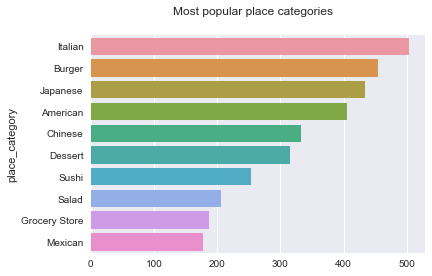

In [62]:
popular_places = df.groupby('place_category').size().sort_values(ascending=False).head(10)

sns.plt.suptitle('Most popular place categories')
sns.barplot(y=popular_places.axes[0],x=popular_places.values)

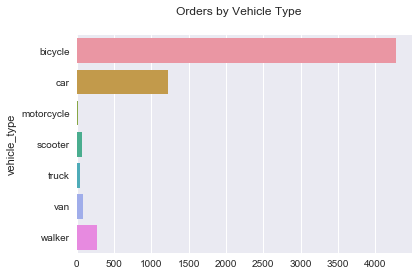

In [17]:
vehicles = df.groupby('vehicle_type').size()

sns.plt.suptitle('Orders by Vehicle Type')
sns.barplot(x=vehicles.values,y=vehicles.axes[0])

## Merchant performance

Merchants for which users take longer to order may have menus that are not optimized for efficient ordering. These merchants can be proactively engaged to prevent the loss of merchants and/or users.

The same analysis can be done for merchants that have a long wait time. Time spent waiting for the food to be ready prevents the Jumpan from making other deliveries.

In [96]:
print('Longest Time to Order')
df.groupby('pickup_place').how_long_it_took_to_order.describe()['mean'].sort_values(ascending=False).head(15)

Longest Time to Order


pickup_place
Joe's Pizza                           00:34:02.009645
16 Handles - UWS Broadway             00:31:06.150557
Lucali                                00:30:14.181875
An Choi                               00:30:01.874689
Blossom Restaurant                    00:27:06.303163
Cariño                                00:26:41.598629
Reserve Cut                           00:25:49.225723
Red Hook Lobster Pound                00:23:48.739210
'wichcraft                            00:23:47.869640
Soba Nippon                           00:22:31.057408
Souvlaki GR                           00:20:01.392662
Le Pain Quotidien                     00:19:53.659442
Socarrat Paella Bar                   00:19:52.538099
The Stanton Social                    00:19:35.853044
Artichoke Basille’s Pizza & Brewery   00:19:27.595301
Name: mean, dtype: timedelta64[ns]

In [97]:
print('Greatest Pickup Wait Times')
df.groupby('pickup_place').pickup_wait_time.describe()['mean'].sort_values(ascending=False).head(15)

Greatest Pickup Wait Times


pickup_place
Denny's                 00:51:44.630496
Trader Joe's            00:51:14.454508
Friend of a Farmer      00:51:00.410526
Jack the Horse Tavern   00:50:45.278773
Lantern Thai Kitchen    00:50:18.834819
Nicola's Restaurant     00:48:40.529988
Gemma at Bowery Hotel   00:46:20.045731
Hester Street Fair      00:45:54.504449
Fette Sau               00:45:49.941610
Amma                    00:44:57.752520
Socarrat Paella Bar     00:44:40.255904
Souen                   00:44:31.441065
An Choi                 00:44:03.647519
Chelsea Market          00:43:27.665979
Fairway Market          00:43:20.536193
Name: mean, dtype: timedelta64[ns]

## Data quality

From a general analysis, the data provided appears to have little data quality issues, but there is a high amount of data with missing item information and missing times for when the Jumpan arrived and left the pickup site.

In addition, there are 16 rows which have exact duplicates. Root cause analysis should have to be performed to see if this is a legitimate issue or actual orders with the same item multiple times.

In [144]:
print('Null values in each column')
df.isnull().sum()

Null values in each column


delivery_id                               0
customer_id                               0
jumpman_id                                0
vehicle_type                              0
pickup_place                              0
place_category                          883
item_name                              1230
item_quantity                          1230
item_category_name                     1230
how_long_it_took_to_order              2945
pickup_lat                                0
pickup_lon                                0
dropoff_lat                               0
dropoff_lon                               0
when_the_delivery_started                 0
when_the_Jumpman_arrived_at_pickup      550
when_the_Jumpman_left_pickup            550
when_the_Jumpman_arrived_at_dropoff       0
pickup_wait_time                        550
order_wait_time                           0
pickup_borough                            0
dropoff_borough                           0
pickup_NTA                      

In [119]:
print('Complete duplicate records')
df[df.duplicated()]

Complete duplicate records


,delivery_id,customer_id,jumpman_id,vehicle_type,pickup_place,place_category,item_name,item_quantity,item_category_name,how_long_it_took_to_order,...,when_the_delivery_started,when_the_Jumpman_arrived_at_pickup,when_the_Jumpman_left_pickup,when_the_Jumpman_arrived_at_dropoff,pickup_wait_time,order_wait_time,pickup_borough,dropoff_borough,pickup_NTA,dropoff_NTA
742,1319722,149234,139558,bicycle,Maimonide of Brooklyn,Vegetarian,Mob Cheeseburger Deluxe,1.0,Entrees,00:06:23.989003,...,2014-10-08 18:57:37.700626,2014-10-08 19:08:42.938479,2014-10-08 19:19:32.491047,2014-10-08 19:37:39.504423,00:10:49.552568,00:40:01.803797,Brooklyn,Brooklyn,DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill,Flatbush
1988,1491424,391367,172130,walker,Veselka,Russian,Small Plate of Pierogis,1.0,Handmade Varenyky (Pierogi),00:07:29.766955,...,2014-10-30 23:08:43.481900,2014-10-30 23:10:31.062088,2014-10-30 23:23:51.143279,2014-10-30 23:29:44.866438,00:13:20.081191,00:21:01.384538,Manhattan,Manhattan,East Village,Lower East Side
2302,1274791,59749,61162,bicycle,Bareburger,Burger,Barest Burger,1.0,Bareburgers,00:04:00.459294,...,2014-10-01 19:06:44.910149,2014-10-01 19:31:56.005935,2014-10-01 19:37:43.279843,2014-10-01 19:51:34.162880,00:05:47.273908,00:44:49.252731,Manhattan,Manhattan,Lenox Hill-Roosevelt Island,Upper East Side-Carnegie Hill
2638,1423447,391860,167596,bicycle,Lucky's Famous Burgers,Burger,Lucky Shake,1.0,Shakes,00:10:07.572874,...,2014-10-22 19:24:39.796568,2014-10-22 19:56:48.461423,2014-10-22 20:03:04.956034,2014-10-22 20:06:06.979942,00:06:16.494611,00:41:27.183374,Manhattan,Manhattan,East Village,Chinatown
3070,1349702,42781,65763,bicycle,2nd Ave Deli,Deli,Potato Knish,2.0,Franks and Knishes,00:06:54.394431,...,2014-10-12 19:52:26.821498,2014-10-12 20:21:08.326255,2014-10-12 20:40:57.055153,2014-10-12 20:49:50.794829,00:19:48.728898,00:57:23.973331,Manhattan,Manhattan,Murray Hill-Kips Bay,Hudson Yards-Chelsea-Flatiron-Union Square
3173,1280728,127149,57496,bicycle,P.J. Clarke's,American,Simply On A Bun,1.0,P.J. Clarke's Hamburgers,00:16:31.335223,...,2014-10-02 18:15:18.193256,2014-10-02 18:37:50.811107,2014-10-02 18:50:58.760766,2014-10-02 19:03:28.535636,00:13:07.949659,00:48:10.342380,Manhattan,Manhattan,Turtle Bay-East Midtown,Lenox Hill-Roosevelt Island
4069,1341790,373689,152676,bicycle,Bareburger,Burger,Country Bacon,1.0,Bareburgers,00:21:38.732788,...,2014-10-11 20:59:28.330299,2014-10-11 21:19:47.335511,2014-10-11 21:40:35.894558,2014-10-11 21:46:48.605621,00:20:48.559047,00:47:20.275322,Manhattan,Manhattan,Lenox Hill-Roosevelt Island,Lenox Hill-Roosevelt Island
4088,1487890,151333,181543,bicycle,Tompkins Square Bagels,Bakery,Gluten-Free,1.0,Bagels,NaT,...,2014-10-30 17:19:00.838744,2014-10-30 17:16:32.175884,2014-10-30 17:26:26.094008,2014-10-30 17:38:25.021882,00:09:53.918124,00:19:24.183138,Manhattan,Manhattan,East Village,West Village
4805,1428278,301695,62487,car,sweetgreen,Salad,Harvest Bowl,1.0,Signatures,00:06:17.250409,...,2014-10-23 12:32:27.416893,2014-10-23 12:59:13.574669,2014-10-23 13:09:07.553461,2014-10-23 13:22:30.534442,00:09:53.978792,00:50:03.117549,Manhattan,Manhattan,Hudson Yards-Chelsea-Flatiron-Union Square,Midtown-Midtown South
4947,1396918,237616,124030,bicycle,Shake Shack,Burger,Shackburger,1.0,Burgers,NaT,...,2014-10-19 12:09:44.071647,2014-10-19 12:16:56.888970,2014-10-19 12:39:23.158535,2014-10-19 12:47:36.847521,00:22:26.269565,00:37:52.775874,Manhattan,Manhattan,Clinton,Midtown-Midtown South


## Future Analysis

By comparing the populations of neighborhoods against deliveries, underserved areas could be determined. This would be able to assist marketing and staffing efforts to improve service to these areas.

In [319]:

## Data from NYC OpenData (https://data.cityofnewyork.us/) 

# PUMA to Census Tract Mapping
df_PUMAtoCensus = pd.read_excel('nyc2010census_tabulation_equiv.xlsx',skiprows=3)
#df_PUMAtoCensus.columns = df_PUMAtoCensus.loc[1]

# 2010 Population by Census Tract
df_CensusTracts = pd.read_csv('New_York_City_Population_By_Census_Tracts.csv')

#Joining the two tables to get population by PUMA
PUMApopulation = pd.merge(df_CensusTracts, 
         df_PUMAtoCensus[['2010 Census Tract','PUMA']], 
         left_on = 'Census Tract', 
         right_on = '2010 Census Tract').groupby('PUMA').sum()['Population']




In [295]:
df_CensusTracts.head(5)

,Borough,Year,FIPS County Code,DCP Borough Code,Census Tract,Population
0,Bronx,2000,5,2,000100,12780
1,Bronx,2000,5,2,000200,3545
2,Bronx,2000,5,2,000400,3314
3,Bronx,2000,5,2,001600,5237
4,Bronx,2000,5,2,001900,1584


In [296]:
df_PUMAtoCensus.head(5)

,Borough,2010 Census Bureau FIPS County Code,2010 NYC Borough Code,2010 Census Tract,PUMA,Neighborhood Tabulation Area (NTA),Unnamed: 6
0,NaN,NaN,NaN,NaN,NaN,Code,Name
1,Bronx,5,2,31000,3704,BX31,Allerton-Pelham Gardens
2,Bronx,5,2,31200,3704,BX31,Allerton-Pelham Gardens
3,Bronx,5,2,31400,3704,BX31,Allerton-Pelham Gardens
4,Bronx,5,2,31600,3704,BX31,Allerton-Pelham Gardens
